<a href="https://colab.research.google.com/github/VladimirBlinov/ColabNotebooks/blob/main/Trading_NET_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install finam-export

In [ ]:
pip install mplfinance

     |████████████████████████████████| 71kB 3.2MB/s 


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import mplfinance as mpf
import logging
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from finam import Exporter, Market, LookupComparator, Timeframe
from finam.utils import click_validate_enum

from scipy.signal import gauss_spline
from scipy.signal import argrelextrema

In [ ]:
exporter = Exporter()
msft = exporter.lookup(market=Market.USA, name='Microsoft',
                          name_comparator=LookupComparator.CONTAINS)
assert len(msft) == 1
data_initial = exporter.download(msft.index[0], market=Market.USA, timeframe=Timeframe.MINUTES15)  # Download data for stock
print(data_initial.tail()) 

         <DATE>    <TIME>  <OPEN>   <HIGH>    <LOW>  <CLOSE>   <VOL>
14931  20210415  21:45:00  258.85  258.950  258.520   258.78   31584
14932  20210415  22:00:00  258.79  259.155  258.490   258.64   43934
14933  20210415  22:15:00  258.65  258.890  258.650   258.83   31542
14934  20210415  22:30:00  258.85  259.490  258.720   259.49   52916
14935  20210415  22:45:00  259.50  259.900  259.125   259.55  160208


In [ ]:
data = data_initial.copy()  # Make copy of initial dataset
data['Date'] = data['<DATE>'].astype(str) + ' ' + data['<TIME>']  # Concatenate data columns as str
data.index = pd.to_datetime(data['Date'])  # Transform index to datetime format
del data['<DATE>'], data['<TIME>'], data['Date']  # Delete initial columns with date

In [ ]:
# Rename columns
data = data.rename(columns={'<OPEN>': 'Open', '<HIGH>': 'High', '<LOW>': 'Low', '<CLOSE>': 'Close', '<VOL>': 'Volume' })
data

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-03 17:30:00,29.91,30.010,29.8800,29.99,4931482
2007-01-03 17:45:00,29.95,29.980,29.8499,29.85,2478193
2007-01-03 18:00:00,29.85,29.920,29.8300,29.91,1454263
2007-01-03 18:15:00,29.90,29.970,29.8800,29.97,2963767
2007-01-03 18:30:00,29.97,30.000,29.9400,30.00,2840720
...,...,...,...,...,...
2021-04-15 21:45:00,258.85,258.950,258.5200,258.78,31584
2021-04-15 22:00:00,258.79,259.155,258.4900,258.64,43934
2021-04-15 22:15:00,258.65,258.890,258.6500,258.83,31542


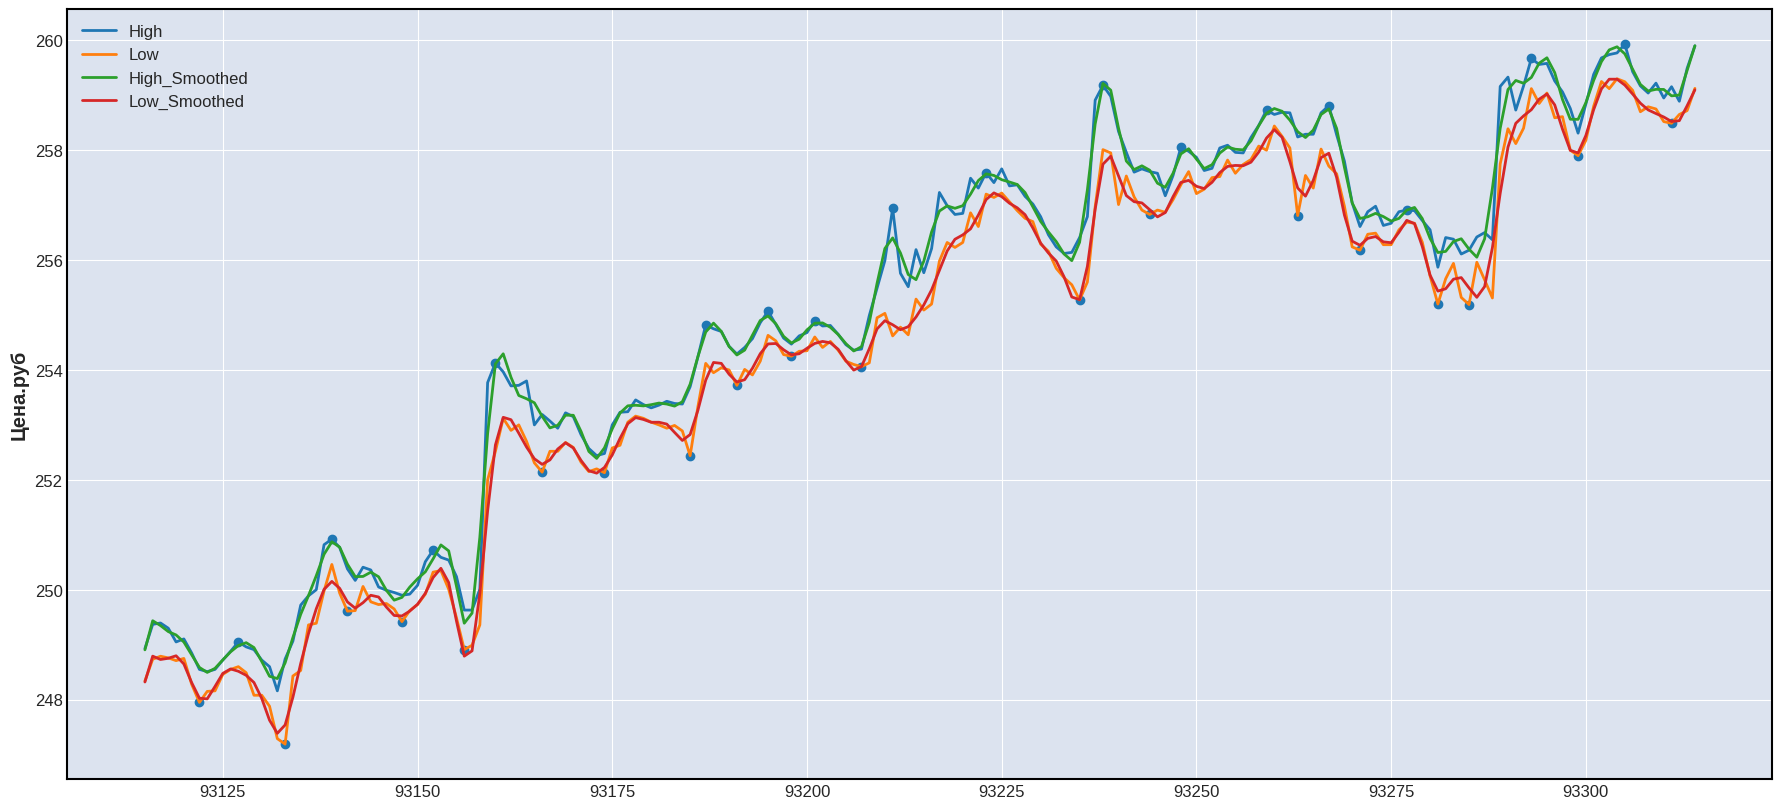

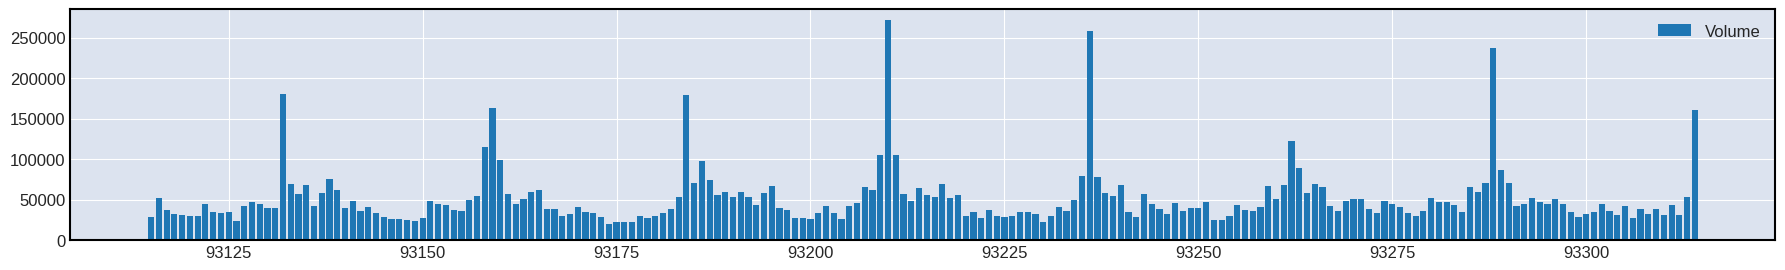

                        Extr
Date                        
2021-04-06 20:15:00  247.950
2021-04-06 21:30:00  249.050
2021-04-07 16:30:00  247.190
2021-04-07 18:00:00  250.920
2021-04-07 18:30:00  249.610
2021-04-07 20:15:00  249.420
2021-04-07 21:15:00  250.720
2021-04-07 22:15:00  248.910
2021-04-08 16:45:00  254.130
2021-04-08 18:15:00  252.140
2021-04-08 20:15:00  252.130
2021-04-09 16:30:00  252.440
2021-04-09 17:00:00  254.820
2021-04-09 18:00:00  253.720
2021-04-09 19:00:00  255.070
2021-04-09 19:45:00  254.250
2021-04-09 20:30:00  254.900
2021-04-09 22:00:00  254.060
2021-04-12 16:30:00  256.940
2021-04-12 19:30:00  257.590
2021-04-12 22:30:00  255.275
2021-04-13 16:45:00  259.180
2021-04-13 18:15:00  256.830
2021-04-13 19:15:00  258.050
2021-04-13 22:00:00  258.730
2021-04-14 16:30:00  256.810
2021-04-14 17:30:00  258.810
2021-04-14 18:30:00  256.180
2021-04-14 20:00:00  256.910
2021-04-14 21:00:00  255.200
2021-04-14 22:00:00  255.190
2021-04-15 17:30:00  259.670
2021-04-15 19:

In [ ]:
interval = -200  # Interval to look back
window_range = 2  # Window range fow smooth timeseries

data = data_initial.copy()  # Make copy of initial dataset
data['Date'] = data['<DATE>'].astype(str) + ' ' + data['<TIME>']  # Concatenate data columns as str
data.index = pd.to_datetime(data['Date'])  # Transform index to datetime format
del data['<DATE>'], data['<TIME>'], data['Date']  # Delete initial columns with date

# Rename columns
data = data.rename(columns={'<OPEN>': 'Open', '<HIGH>': 'High', '<LOW>': 'Low', '<CLOSE>': 'Close', '<VOL>': 'Volume' })

#data = data_with_date.copy()  # Make copy of initial data with timestamp
time_st = data.index  # Store timestamps
data = data.reset_index(drop=True)  # Reset indexes to figures

def gauss_smooth(data):
  '''
  This function makes gaussian smooth of timeseries.
  arg: series
  The timeseries to smooth
  return: series
  Smoothed timeseries
  '''
  y_data = data.copy()
  y_data = y_data.reset_index(drop=True)
  x = y_data.index.values.reshape(-1,1)  # Take values of index as x
  y = y_data.values.reshape(-1,1).copy()  # Take values of series as y

  kernel = 0.2 * RBF(length_scale=0.8, length_scale_bounds=(1e-3, 4)) \
      + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-3, 1e+1))
  
  # Define Gaussian process
  gp = GaussianProcessRegressor(kernel=kernel,
                                alpha=0.0).fit(x, y)
  # Make smooth
  y_mean, y_cov = gp.predict(x, return_cov=True)
  return y_mean

def get_max_min(high, low, window_range):
  '''
  This function gets extremums of the timeseries using
  high: series
  The timeseries of High price values
  low: series
  The timeseries of Low price values
  range: int
  Size of the window to find real value near the smoothed extremum
  return: series of extremums, series of smoothed high, series of smoothed low
  '''
  high_smoothed = gauss_smooth(high)  # Smooth high timeseries
  low_smoothed = gauss_smooth(low) # Smooth low timeseries
  local_max = argrelextrema(high_smoothed, np.greater, order=4)[0] # Find maximums
  local_min = argrelextrema(low_smoothed, np.less, order=4)[0] # Find minimums

  price_local_max = []
  for i in local_max:
    if (i>window_range) and (i < (len(high) - window_range)):
      price_local_max.append(high.iloc[i-window_range:i+window_range].idxmax())

  price_local_min = []
  for i in local_min:
    if (i>window_range) and (i < (len(high) - window_range)):
      price_local_min.append(low.iloc[i-window_range:i+window_range].idxmin())

  maxima = pd.DataFrame(high.loc[price_local_max])
  minima = pd.DataFrame(low.loc[price_local_min])
  maxmin = pd.concat([maxima, minima]).sort_index()
  maxmin = maxmin[~maxmin.index.duplicated()]
  maxmin['Extr'] = maxmin.fillna(0).sum(axis=1)
  del maxmin['High'], maxmin['Low']

  return maxmin, high_smoothed, low_smoothed

# Get extremums and smoothed High, Low
maxmin, high_smoothed, low_smoothed = get_max_min(data.iloc[interval:,1], data.iloc[interval:,2], window_range )

col = data.columns.tolist()
# Draw the data in channels
plt.figure(figsize=(22,10))
for i in range(1,3):
  plt.plot(data.iloc[interval:,i], 
          label=col[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.plot(data.iloc[interval:].index, high_smoothed, label = 'High_Smoothed')
plt.plot(data.iloc[interval:].index, low_smoothed, label = 'Low_Smoothed')
plt.scatter(maxmin.index, maxmin)
plt.legend()
plt.show()

# Channel volume
plt.figure(figsize=(22,3))
plt.bar(x=data.index[interval:], height=data.iloc[interval:,4], label="Volume")
plt.legend()
plt.show()

# Return timestamps as indexes
maxmin.index = time_st[maxmin.index]
data.index = time_st[data.index]

print(maxmin)


# Join extremums to the dataset
data = data.join(maxmin, how='left')
print(data)
#print(data)

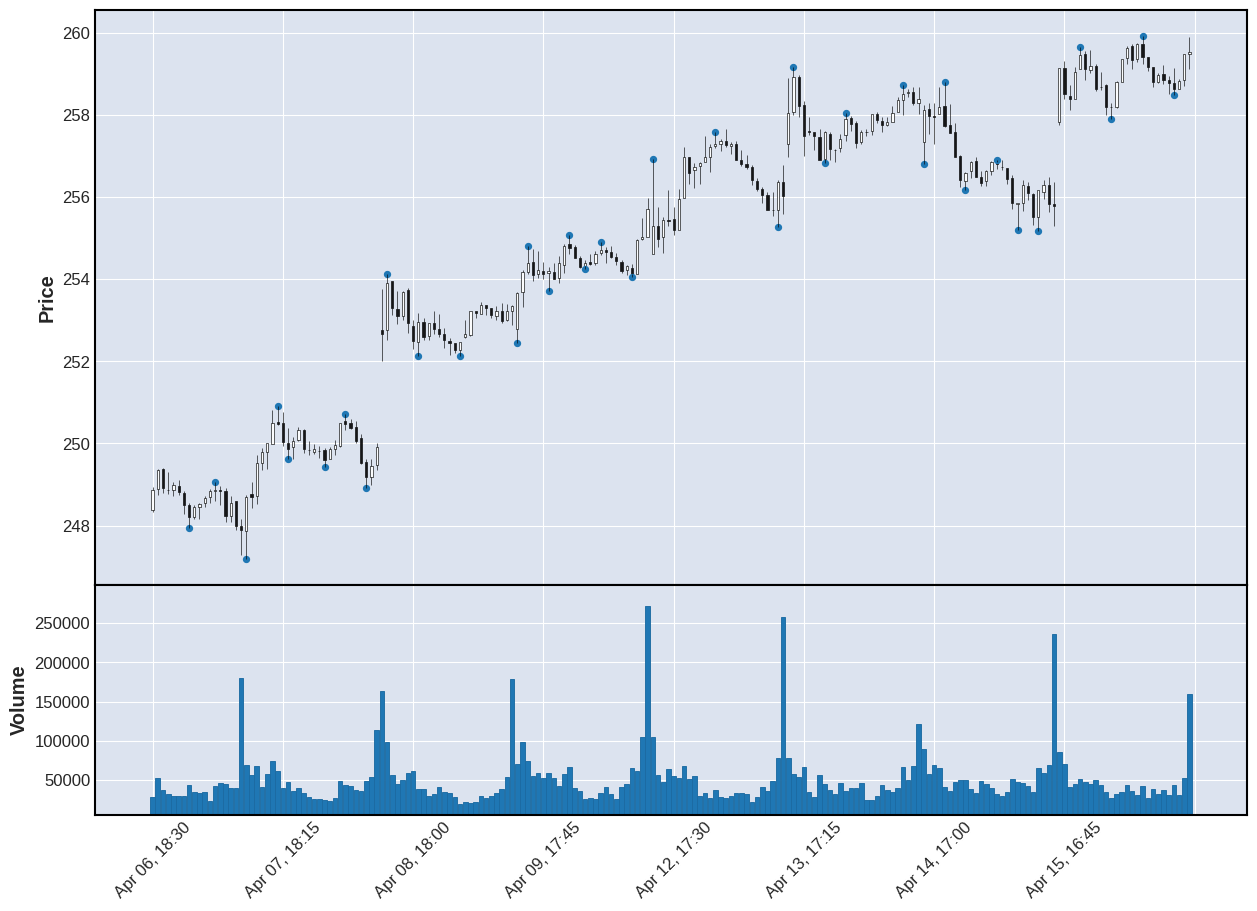

In [ ]:
# Plot candels with extremums
add_maxmin = mpf.make_addplot(data.iloc[interval:,5], type='scatter', secondary_y=False)
mpf.plot(data.iloc[interval:,:5], type='candle', volume=True, addplot=add_maxmin, figscale=2)
plt.show() 

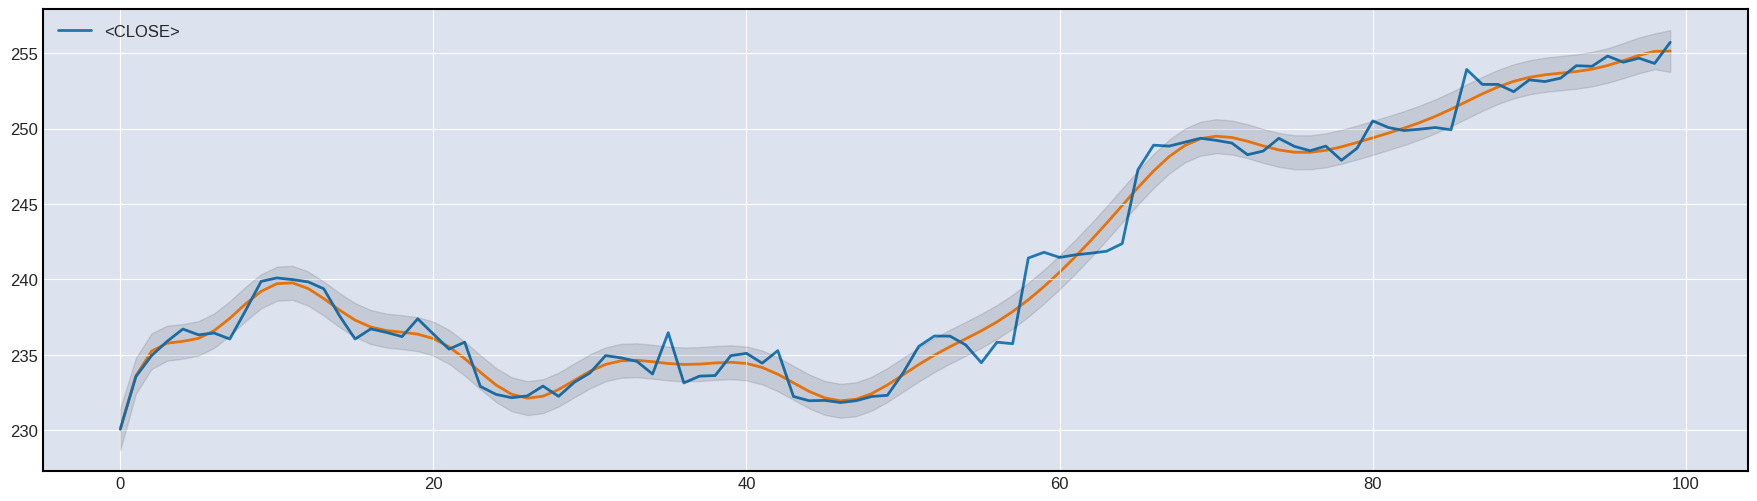

In [ ]:
interval = -100
y_data = data.iloc[interval:,3].copy()
y_data = y_data.reset_index(drop=True)
x = y_data.index.values.reshape(-1,1)
y = y_data.values.reshape(-1,1).copy()

kernel = 0.2 * RBF(length_scale=0.9, length_scale_bounds=(1e-5, 8)) \
    + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-3, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(x, y)

y_mean, y_cov = gp.predict(x, return_cov=True)
plt.figure(figsize=(22,6))
plt.plot(y_data, zorder=7, label='<CLOSE>')
plt.plot(x, y_mean, zorder=0)
plt.fill_between(x.reshape(1,-1)[0], y_mean.reshape(1,-1)[0] - np.sqrt(np.diag(y_cov)),
                 y_mean.reshape(1,-1)[0] + np.sqrt(np.diag(y_cov)),
                 alpha=0.1, color='k', zorder=9)

plt.legend()
plt.show()